In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import random
import IPython.display as ipd
from glob import glob

# Define paths (edit based on your environment)
base_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm"
train_path = os.path.join(base_path, "training")
val_path = os.path.join(base_path, "validation")
test_path = os.path.join(base_path, "testing")

In [2]:
## Visualizing the dataset playing any random audio

def get_file_paths(folder):
    return glob(os.path.join(folder, "**", "*.wav"), recursive=True)

# Load one audio file for visualization
all_train_files = get_file_paths(train_path)
random_audio_file = random.choice(all_train_files)
print("Sample audio:", random_audio_file)

# Load with Librosa
signal, sr = librosa.load(random_audio_file, sr=32000)  # Target SR = 32kHz
print(f"Audio Duration: {len(signal)/sr:.2f} seconds, Sample Rate: {sr}")

# Play audio
ipd.Audio(signal, rate=sr)

Sample audio: /kaggle/input/the-fake-or-real-dataset/for-norm/for-norm/training/real/file32738.wav_16k.wav_norm.wav_mono.wav_silence.wav
Audio Duration: 3.38 seconds, Sample Rate: 32000


In [3]:
from pathlib import Path
import pandas as pd

DATASET_PATH = Path("/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm")

def get_file_paths_and_labels(split_folder):
    split_path = DATASET_PATH / split_folder
    filepaths, labels = [], []
    
    for label in ['real', 'fake']:
        label_path = split_path / label
        #print(label_path)
        if not label_path.exists():
            continue
        for wav_file in label_path.glob("*.wav"):
            #print(wav_file)
            filepaths.append(str(wav_file))
            labels.append(label)
    
    return pd.DataFrame({'filepath': filepaths, 'label': labels})

# Reload using corrected path
train_df = get_file_paths_and_labels("training")
val_df = get_file_paths_and_labels("validation")
test_df = get_file_paths_and_labels("testing")

# Check contents
## training shape
print("Train shape:", train_df.shape)
print(train_df['label'].value_counts())

print()
# validation shape
print("Validation shape:", val_df.shape)
print(val_df['label'].value_counts())

print()
# test shape
print("Testing shape:", test_df.shape)
print(test_df['label'].value_counts())

Train shape: (53868, 2)
label
real    26941
fake    26927
Name: count, dtype: int64

Validation shape: (10798, 2)
label
real    5400
fake    5398
Name: count, dtype: int64

Testing shape: (4634, 2)
label
fake    2370
real    2264
Name: count, dtype: int64


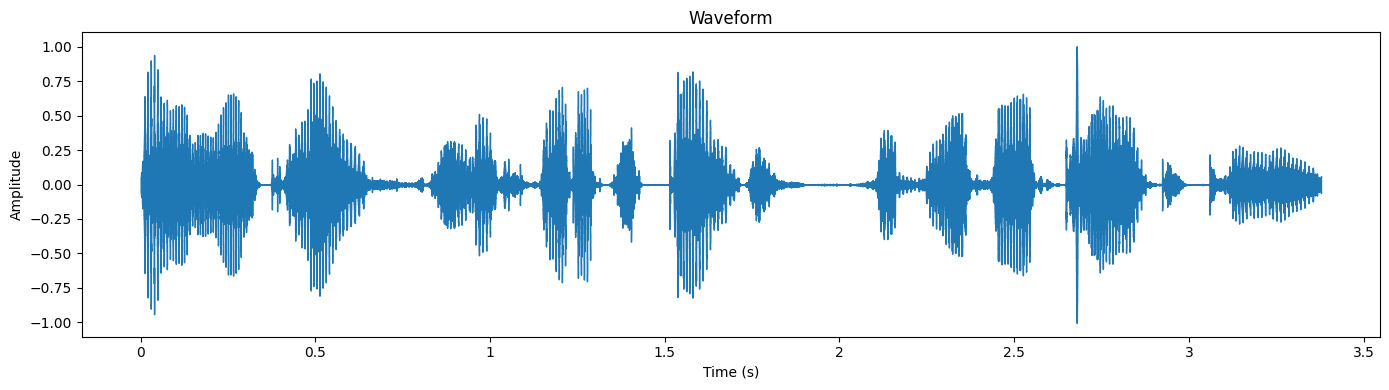

In [4]:
## waveform visualization

plt.figure(figsize=(14, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

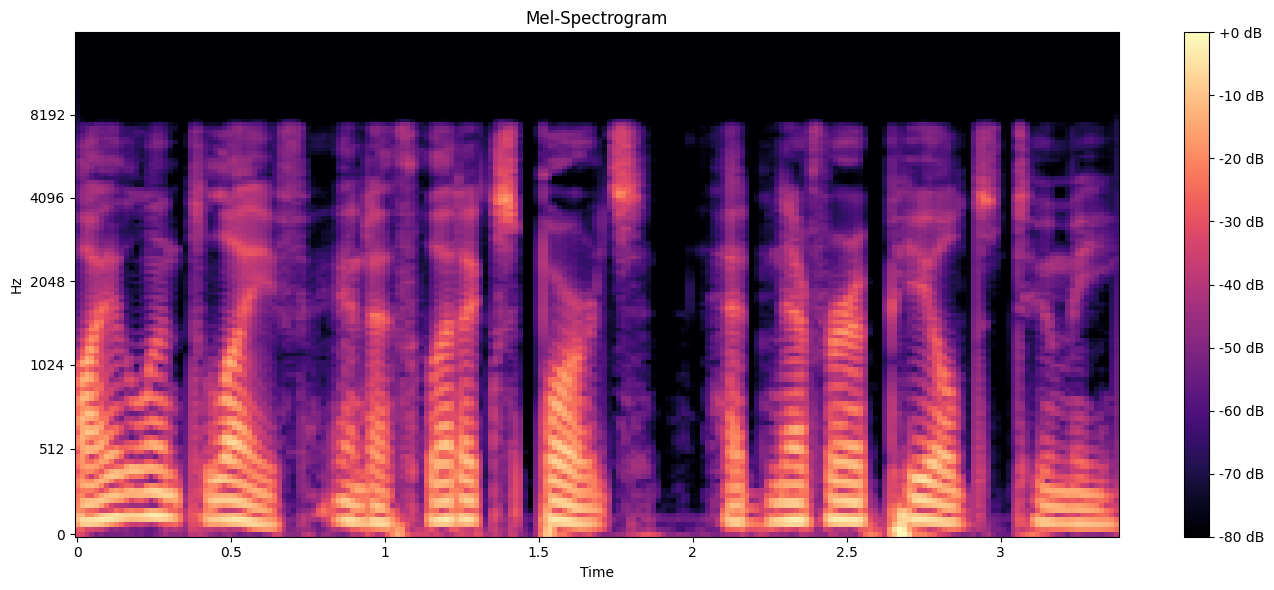

In [5]:
## Mel spectogram visualization

mel_spec = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128, fmax=16000)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=16000)
plt.title('Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [6]:
## Data Preprocessing
import torchaudio
import librosa
import os
import numpy as np
import torch

SAMPLE_RATE = 32000

def preprocess_audio(file_path):
    waveform, sr = torchaudio.load(file_path)
    if sr != SAMPLE_RATE:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=SAMPLE_RATE)(waveform)
    waveform = waveform.mean(dim=0, keepdim=True)  # Mono
    return waveform

def get_melspectrogram(waveform):
    mel_spec = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_mels=128
    )(waveform)
    return torchaudio.transforms.AmplitudeToDB()(mel_spec)

In [7]:
## Model defintion

import timm
import torch.nn as nn

class PaSSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.passt = timm.create_model("hf_hub:timm/PaSST_S_k400", pretrained=True, num_classes=0)
        self.head = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.passt(x)
        return self.head(x)


In [8]:
## Training loop

from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix

# Custom Dataset (simplified)
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.file_paths = file_paths
        self.labels = labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        waveform = preprocess_audio(self.file_paths[idx])
        mel = get_melspectrogram(waveform)
        return mel, self.labels[idx]

# Training function
def train(model, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    for epoch in range(epochs):
        model.train()
        for X, y in train_loader:
            X, y = X.cuda(), y.cuda()
            out = model(X)
            loss = criterion(out, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [9]:
!pip install gradio
!pip install hear21passt

In [14]:
import os
import torch
import torchaudio
import timm
import librosa
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import gradio as gr
from hear21passt.base import get_basic_model, get_model_passt
from torch.optim import AdamW
from collections import defaultdict

In [15]:
# ----------- CONFIG -----------
SAMPLE_RATE = 32000
N_MELS = 128
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# ----------- DATA LOADER (UPDATED) -----------
class AudioDataset(Dataset):
    def __init__(self, file_list, max_length=512):
        self.file_list = file_list
        self.max_length = max_length

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, label = self.file_list[idx]
        try:
            waveform, _ = torchaudio.load(file_path)
            waveform = waveform.mean(dim=0, keepdim=True)  # convert to mono
            
            mel_spec = torchaudio.transforms.MelSpectrogram(
                sample_rate=SAMPLE_RATE, n_mels=N_MELS)(waveform)
            mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
            
            # Pad or truncate to fixed length
            if mel_spec_db.size(-1) < self.max_length:
                pad_amt = self.max_length - mel_spec_db.size(-1)
                mel_spec_db = torch.nn.functional.pad(mel_spec_db, (0, pad_amt))
            else:
                mel_spec_db = mel_spec_db[:, :, :self.max_length]
            
            return mel_spec_db, label
            
        except Exception as e:
            print(f'Skipping Corrupted file {idx}')
            return None
             
             
        


In [18]:
## MODEL

# ----------- MODEL -----------
class PaSSTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = get_basic_model(mode="logits")
        self.backbone.net = get_model_passt(arch="passt_s_swa_p16_128_ap476", n_classes=512)  # Use default output size
        self.mlp = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,2),
        )

    def forward(self, x):
        x, _ = self.backbone.net(x)
        x = self.mlp(x)
        return x

In [19]:
from tqdm import tqdm
# ----------- TRAINING -----------
def train(model, train_loader, val_loader, epochs=10):
    model = model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for mel, label in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            if mel is None:
                continue
            mel, label = mel.to(DEVICE), label.to(DEVICE)
            output = model(mel)
            loss = criterion(output, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

        evaluate(model, val_loader)

In [20]:
# ----------- EVALUATION -----------
def evaluate(model, dataloader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for mel, label in dataloader:
            mel = mel.to(DEVICE)
            out = model(mel)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(label.numpy())
    print(classification_report(targets, preds))
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.show()

In [21]:
# ----------- t-SNE VISUALIZATION -----------
def tsne_embeddings(model, dataloader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for mel, label in dataloader:
            mel = mel.to(DEVICE)
            feats, _ = model.backbone.net.forward_features(mel)
            features.append(feats.cpu().numpy())
            labels += label.numpy().tolist()
    features = np.vstack(features)
    tsne = TSNE(n_components=2).fit_transform(features)
    plt.scatter(tsne[:,0], tsne[:,1], c=labels, cmap='coolwarm')
    plt.title("t-SNE of Embeddings")
    plt.show()

In [22]:
# ----------- REAL-TIME MIC INFERENCE -----------
def predict_mic(audio_path):
    model.eval()
    waveform, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
    waveform = torch.tensor(waveform).unsqueeze(0)
    mel = torchaudio.transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_mels=N_MELS)(waveform)
    mel = torchaudio.transforms.AmplitudeToDB()(mel)
    mel = mel.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output = model(mel)
    return "REAL" if output.argmax(1).item() == 0 else "FAKE"

In [23]:
# ----------- GRADIO UI -----------
iface = gr.Interface(fn=predict_mic, inputs=gr.Audio(type="filepath", label="Mic Input"), outputs="text")


In [24]:
# ----------- MAIN EXECUTION (Dataset from for-norm) -----------
def load_dataset(split_dir):
    file_list = []
    for label_name in ["real", "fake"]:
        label = 0 if label_name == "real" else 1
        path = os.path.join(split_dir, label_name)
        for fname in os.listdir(path):
            if fname.endswith(".wav"):
                file_list.append((os.path.join(path, fname), label))
    return file_list

def balanced_sample(file_list, total_samples):
    label_to_files = defaultdict(list)
    for path, label in file_list:
        label_to_files[label].append((path, label))

    per_class = total_samples // 2
    sampled = []
    for label in [0, 1]:
        sampled.extend(random.sample(label_to_files[label], min(per_class, len(label_to_files[label]))))
    return sampled

In [25]:

base_path = "/kaggle/input/the-fake-or-real-dataset/for-norm/for-norm"
train_list = load_dataset(os.path.join(base_path, "training"))
val_list = load_dataset(os.path.join(base_path, "validation"))
test_list = load_dataset(os.path.join(base_path, "testing"))

In [26]:
# import random
# ## selecting random samples
# random.seed(42)
# train_list = balanced_sample(train_list, 5000)
# val_list = balanced_sample(val_list, 1000)
# test_list = balanced_sample(test_list, 1000)

In [27]:
train_dataset = AudioDataset(train_list)
val_dataset = AudioDataset(val_list)
test_dataset = AudioDataset(test_list)

In [28]:
def safe_collate(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
         return None  # Avoid batch of only corrupted data
    return torch.utils.data.dataloader.default_collate(batch)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn = safe_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn = safe_collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn = safe_collate)

In [29]:
model = PaSSTClassifier()



 Loading PASST TRAINED ON AUDISET 




/usr/local/lib/python3.11/dist-packages/hear21passt/models/helpers/vit_helpers.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(pretrained_loc, m

PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
     

Epoch 1:   0%|          | 0/3367 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


x torch.Size([16, 1, 128, 512])
self.norm(x) torch.Size([16, 768, 12, 50])
 patch_embed :  torch.Size([16, 768, 12, 50])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 CUT time_new_pos_embed.shape torch.Size([1, 768, 1, 50])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([16, 600, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([16, 1, 768])
 self.dist_token.shape torch.Size([16, 1, 768])
 final sequence x torch.Size([16, 602, 768])


/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


 after 12 atten blocks x torch.Size([16, 602, 768])
forward_features torch.Size([16, 768])
head torch.Size([16, 512])


Epoch 1:  42%|████▏     | 1407/3367 [59:51<1:22:29,  2.53s/it]

Skipping Corrupted file 22490


Epoch 1:  68%|██████▊   | 2298/3367 [1:37:59<44:42,  2.51s/it]  

Skipping Corrupted file 16442


Epoch 1: 100%|██████████| 3367/3367 [2:23:35<00:00,  2.56s/it]


Epoch 1, Loss: 0.0635
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5400
           1       1.00      0.99      0.99      5398

    accuracy                           0.99     10798
   macro avg       0.99      0.99      0.99     10798
weighted avg       0.99      0.99      0.99     10798



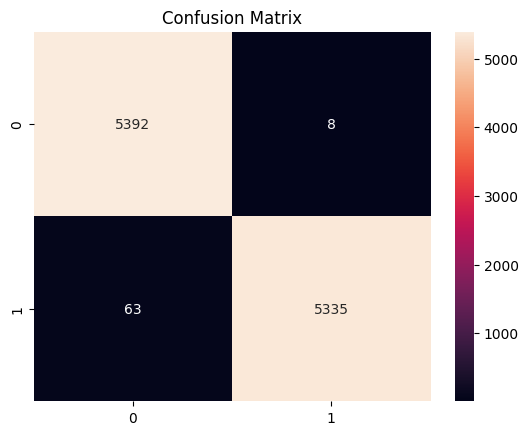

Epoch 2:   0%|          | 0/3367 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 2:  46%|████▋     | 1559/3367 [1:03:13<1:12:42,  2.41s/it]

Skipping Corrupted file 22490


Epoch 2:  76%|███████▌  | 2554/3367 [1:43:33<32:53,  2.43s/it]  

Skipping Corrupted file 16442


Epoch 2: 100%|██████████| 3367/3367 [2:16:32<00:00,  2.43s/it]


Epoch 2, Loss: 0.0167
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5400
           1       1.00      1.00      1.00      5398

    accuracy                           1.00     10798
   macro avg       1.00      1.00      1.00     10798
weighted avg       1.00      1.00      1.00     10798



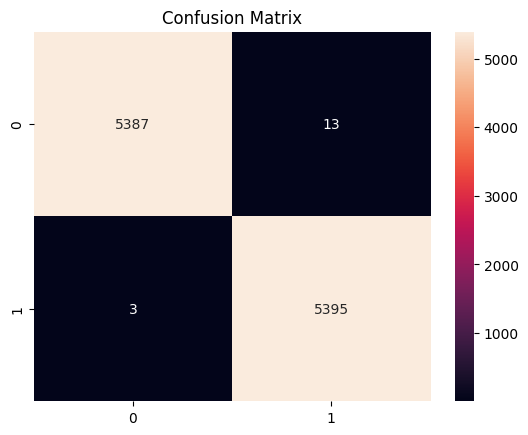

Epoch 3:   0%|          | 0/3367 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")
Epoch 3:  18%|█▊        | 610/3367 [24:42<1:50:34,  2.41s/it]

Skipping Corrupted file 16442


Epoch 3:  57%|█████▋    | 1917/3367 [1:17:47<58:31,  2.42s/it]  

Skipping Corrupted file 22490


Epoch 3: 100%|██████████| 3367/3367 [2:16:32<00:00,  2.43s/it]


Epoch 3, Loss: 0.0120
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      5400
           1       0.99      1.00      1.00      5398

    accuracy                           1.00     10798
   macro avg       1.00      1.00      1.00     10798
weighted avg       1.00      1.00      1.00     10798



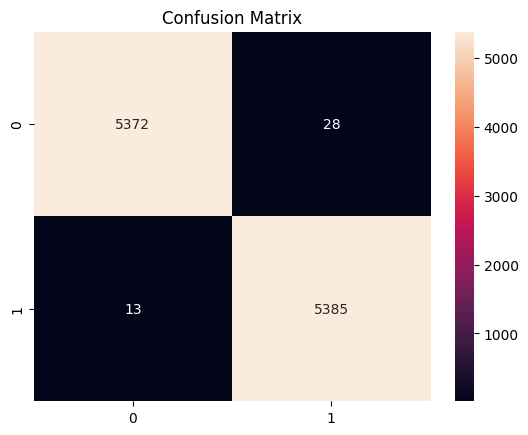

In [30]:
train(model, train_loader, val_loader, epochs=3)

import torch
torch.save(model.state_dict(), "/kaggle/working/passt_weights_full_dataset.pth")

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


              precision    recall  f1-score   support

           0       0.58      0.93      0.71      2264
           1       0.84      0.36      0.50      2370

    accuracy                           0.64      4634
   macro avg       0.71      0.64      0.61      4634
weighted avg       0.71      0.64      0.60      4634



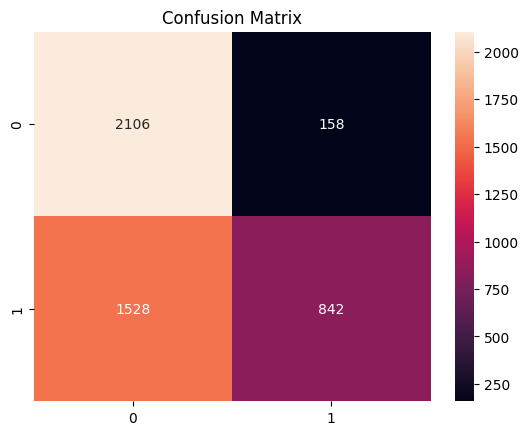

In [31]:
## confusion matrix for testing

evaluate(model, test_loader)

/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*512) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


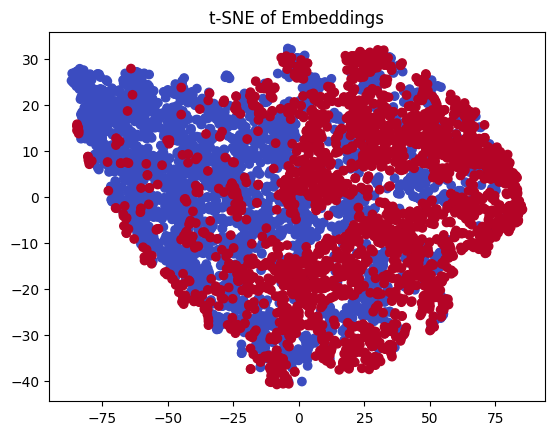

In [32]:
## tsne embedding visualization

tsne_embeddings(model, test_loader)